In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

**Variable	Definition	Key**

* **survival**	Survival	0 = No, 1 = Yes
* **pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* **sex**	Sex	
* **Age**	Age in years	
* **sibsp**	# of siblings / spouses aboard the Titanic	
* **parch**	# of parents / children aboard the Titanic	
* **ticket**	Ticket number	
* **fare**	Passenger fare	
* **cabin**	Cabin number	
* **embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# Data

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1 - EDA

In [61]:
# Reading train data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')

# Reading test data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.shape

(891, 12)

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_median = pd.DataFrame(train_data.median()).reset_index().rename(columns = {0: 'Median',
                                                                                'index': 'columns_names'})

train_median

,columns_names,Median
0,PassengerId,446.0000
1,Survived,0.0000
2,Pclass,3.0000
3,Age,28.0000
4,SibSp,0.0000
5,Parch,0.0000
6,Fare,14.4542


In [9]:
# Checking number of null values in the dataset... output as DF.

train_nulls = pd.DataFrame(train_data.isna().sum()).reset_index().rename(columns = {0: 'total_nulls', 'index': 'columns_names'})

train_nulls['percent_nulls'] = pd.Series()

for i in train_nulls.index:
    train_nulls.percent_nulls[i] = (train_data[train_nulls['columns_names'][i]].isna().sum()/train_data.PassengerId.count())*100
    
train_nulls.sort_values('total_nulls')

,columns_names,total_nulls,percent_nulls
0,PassengerId,0,0.000000
1,Survived,0,0.000000
2,Pclass,0,0.000000
3,Name,0,0.000000
4,Sex,0,0.000000
6,SibSp,0,0.000000
7,Parch,0,0.000000
8,Ticket,0,0.000000
9,Fare,0,0.000000
11,Embarked,2,0.224467


# 1.1 - DataViz

**Here I present some questions to better understand what may have influenced the survival rate...**

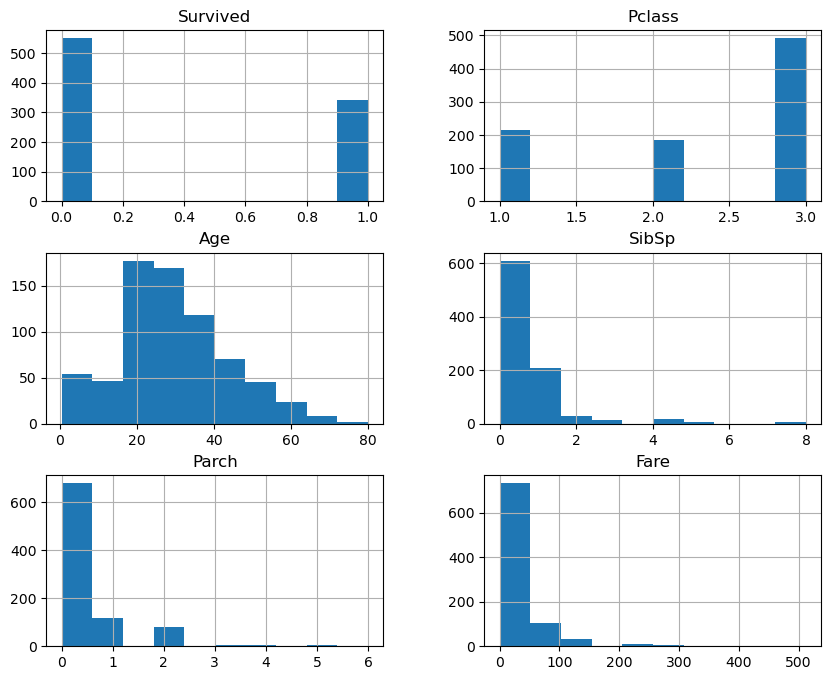

In [10]:
data_hist = train_data[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

data_hist.hist(figsize=(10,8))
plt.show()

In [11]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

**What is the relationship between survival and gender(sex)?**

<AxesSubplot:xlabel='Sex'>

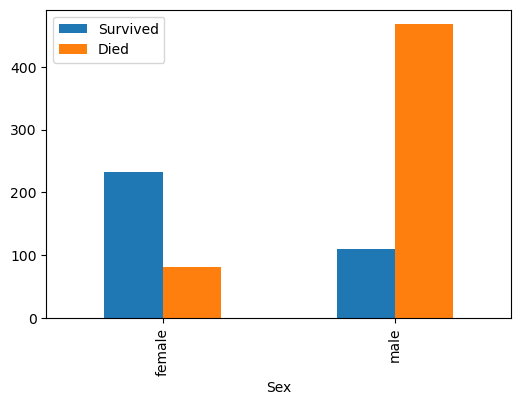

In [12]:
train_data['Died'] = 1-train_data['Survived']

train_data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar',
                                                               figsize=(6,4))

In [ ]:
train_data['Pclass'].value_counts()

**Does class influence survival?**

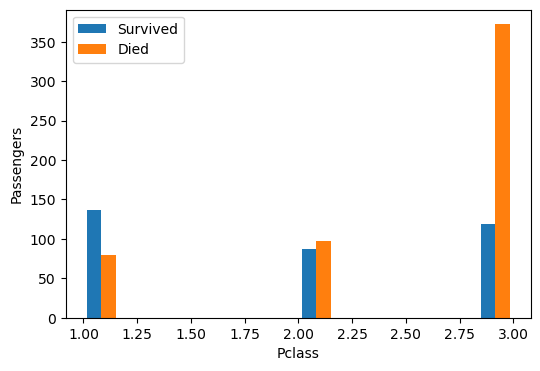

In [13]:
fig = plt.figure(figsize=(6,4))

plt.hist([train_data[train_data['Survived']==1]['Pclass'],
         train_data[train_data['Survived']==0]['Pclass']],
         bins=12, label=['Survived', 'Died'])

plt.xlabel('Pclass')
plt.ylabel('Passengers')
plt.legend()

In [17]:
train_data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

**Did travelling with other family members contribute to the rate of non-survivors?**

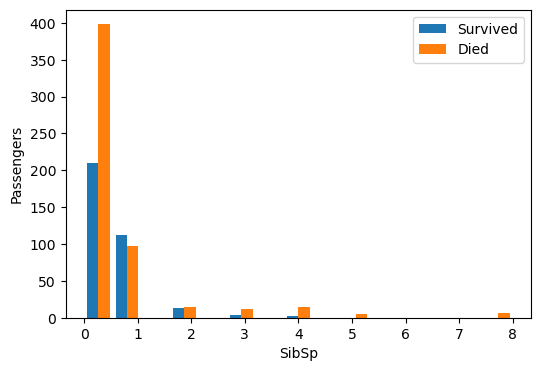

In [14]:
fig = plt.figure(figsize=(6,4))

plt.hist([train_data[train_data['Survived']==1]['SibSp'],
         train_data[train_data['Survived']==0]['SibSp']],
        bins=15, label=['Survived', 'Died'])

plt.xlabel('SibSp')
plt.ylabel('Passengers')
plt.legend()

**How has the fare affected the survival rate?**

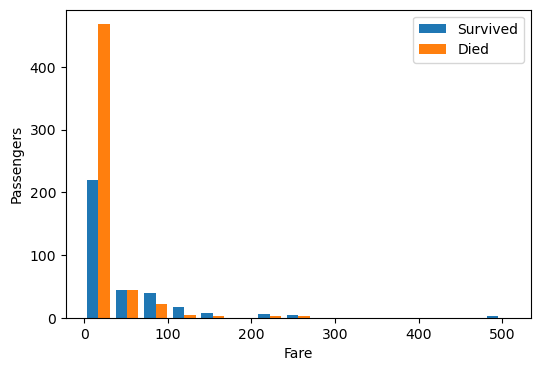

In [16]:
fig = plt.figure(figsize=(6,4))

plt.hist([train_data[train_data['Survived']==1]['Fare'],
         train_data[train_data['Survived']==0]['Fare']],
        bins=15, label=['Survived', 'Died'])

plt.xlabel('Fare')
plt.ylabel('Passengers')
plt.legend()

# 2 - Feature Engineering

In [62]:
train_data_fe = train_data.dropna(subset=['Embarked'])

train_data_fe.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [63]:
# Converting categorical into numerical

train_data_fe.Sex=train_data_fe.Sex.map({'female':0,'male':1})

train_data_fe.Embarked=train_data_fe.Embarked.map({'S':0,'C':1,'Q':2})

In [64]:
# Median age for each sex
md_age_male = train_data_fe[train_data_fe['Sex']==1]['Age'].mean()
md_age_famale = train_data_fe[train_data_fe['Sex']==0]['Age'].mean()

# Filling null values with respective median age
train_data_fe.loc[(train_data_fe.Age.isnull()) & (train_data_fe['Sex']==0),'Age']=md_age_famale
train_data_fe.loc[(train_data_fe.Age.isnull()) & (train_data_fe['Sex']==1),'Age']=md_age_male

train_data_fe.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [65]:
train_data_fe.Age = train_data_fe.Age.fillna(train_data_fe.Age.mean())

train_data_fe.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [66]:
train_data_fe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0


In [27]:
train_data_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    int64  
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    int64  
 12  Died         889 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 97.2+ KB


In [68]:
X = train_data_fe[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y = train_data_fe['Survived']

In [69]:
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# 3 - Modeling and Avaluetion

In [70]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=95)

In [71]:
x_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

**Model 1 - LR**

In [72]:
from sklearn.linear_model import LogisticRegression as LR

LR_model = LR()
LR_model.fit(x_train,y_train)

y_predict = LR_model.predict(x_test)

from sklearn.metrics import accuracy_score, f1_score

print('Accuracy of the LR model was: ' + str(accuracy_score(y_test,y_predict)))
print('F1_score of the LR model was: ' + str(f1_score(y_test,y_predict)))

Accuracy of the LR model was: 0.8202247191011236
F1_score of the LR model was: 0.754601226993865


**Model 2 - RFC**

In [73]:
from sklearn.ensemble import RandomForestClassifier as RFC

RFC_model = RFC(random_state=1)
RFC_model.fit(x_train,y_train)

y_predict_2 = RFC_model.predict(x_test)

print('Accuracy of the RFC model was: ' + str(accuracy_score(y_test,y_predict_2)))
print('F1_score of the RFC model was: ' + str(f1_score(y_test,y_predict_2)))

Accuracy of the RFC model was: 0.7955056179775281
F1_score of the RFC model was: 0.7450980392156863


**Model 3 - GBC**

In [74]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

GBC_model = GBC() # learning_rate= 0.02 , max_depth= 3 , n_estimators= 50,min_samples_split=3

GBC_model.fit(x_train,y_train)

y_predict_3 = GBC_model.predict(x_test)

print('Accuracy of the LR model was: ' + str(accuracy_score(y_test,y_predict_3)))
print('F1_score of the LR model was: ' + str(f1_score(y_test,y_predict_3)))

Accuracy of the LR model was: 0.8404494382022472
F1_score of the LR model was: 0.7815384615384614


# 4 - Test_data and Predict

In [75]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [76]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [77]:
test_data.Sex = test_data.Sex.map({'female':0, 'male':1})

test_data.Embarked = test_data.Embarked.map({'S':0,'C':1,'Q':2})

In [78]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,0


In [79]:
test_data_fe = test_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

test_data_fe

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,2
1,3,0,47.0,1,0,7.0000,0
2,2,1,62.0,0,0,9.6875,2
3,3,1,27.0,0,0,8.6625,0
4,3,0,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,0
414,1,0,39.0,0,0,108.9000,1
415,3,1,38.5,0,0,7.2500,0
416,3,1,NaN,0,0,8.0500,0


In [54]:
test_data_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       0 non-null      float64
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  0 non-null      float64
dtypes: float64(4), int64(3)
memory usage: 23.0 KB


In [80]:
test_data_fe.Age = test_data_fe.Age.fillna(test_data.Age.mean())

test_data_fe.Fare = test_data_fe.Fare.fillna(test_data.Fare.median())

test_data_fe.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [81]:
predictions = LR_model.predict(test_data_fe)

predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Saving model 1

In [ ]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId,'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")